En esta práctica, aprenderemos a utilizar diferentes tipos de redes neuronales para realizar el análisis de sentimiento del dataset de Multilingual Amazon Reviews Corpus.

# Análisis, preprocesamiento y preparación de los datos

In [ ]:
#Cargamos los datasets

from google.colab import drive

drive.mount('/content/drive')
amazon_en_train = '/content/drive/MyDrive/Máster NLP UR/amazon_dataset_en_train.csv'
amazon_en_dev = '/content/drive/MyDrive/Máster NLP UR/amazon_dataset_en_dev.csv'
amazon_en_test = '/content/drive/MyDrive/Máster NLP UR/amazon_dataset_en_test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [ ]:
import pandas as pd

file_names = [(amazon_en_train, "train"), (amazon_en_dev, "dev"), (amazon_en_test, "test")]

df_list = []

for file_name, split_name in file_names:
  df = pd.read_csv(file_name)
  df["split"] = split_name
  df_list.append(df)

df = pd.concat(df_list)
df

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,split
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture,train
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement,train
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home,train
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless,train
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc,train
...,...,...,...,...,...,...,...,...,...
4995,en_0681530,product_en_0198517,reviewer_en_0539725,5,"It's still early, but so far the scales seems ...",Very sleek.,en,drugstore,test
4996,en_0157408,product_en_0206198,reviewer_en_0605408,5,I’ve used this face mask a few times now and i...,... face mask a few times now and it works gre...,en,beauty,test
4997,en_0542558,product_en_0525205,reviewer_en_0727937,5,Great price. Good quality.,Five Stars,en,home,test
4998,en_0754850,product_en_0613095,reviewer_en_0643466,5,Fits my 2016 F150 XLT great. Now I dont have t...,2016 F150 XLT,en,automotive,test


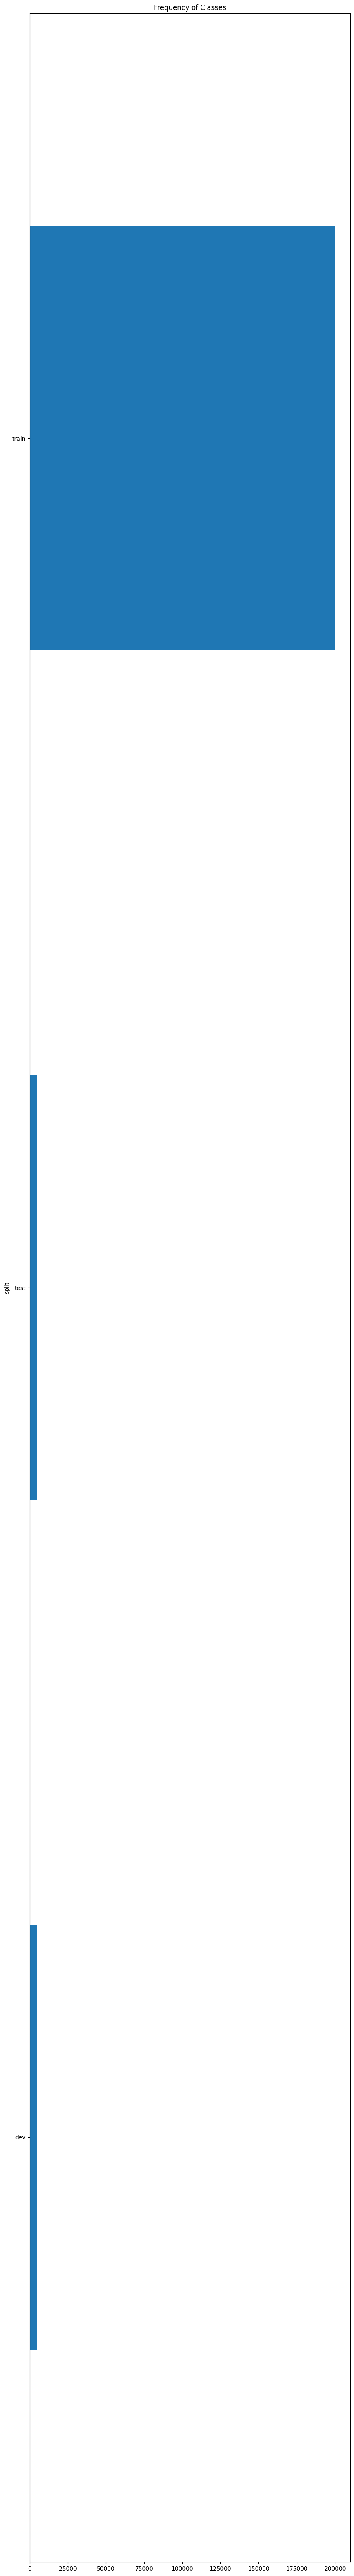

In [ ]:
# Distribución de instancias por split

import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

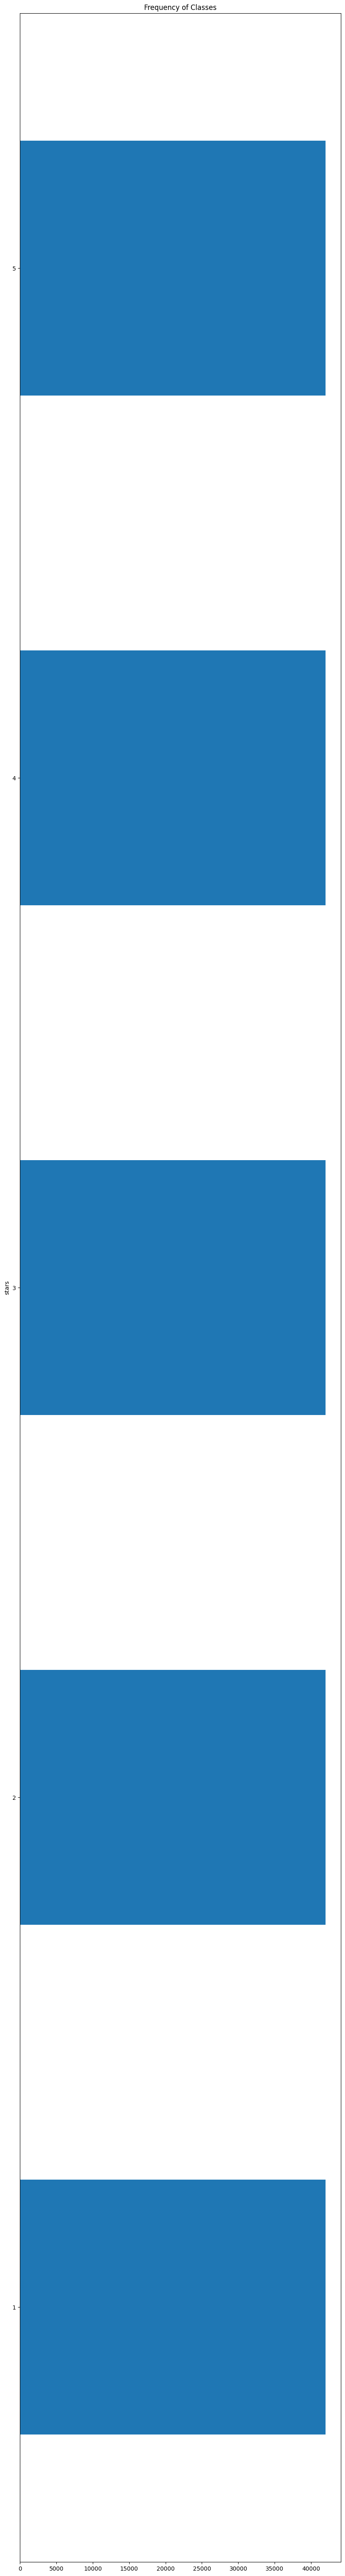

In [ ]:
# Distribucion de instancias por clases (i.e. estrellas)

df["stars"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [ ]:
# Nos quedamos con las columnas que nos interesan
df = df[['review_body', 'stars', 'split']]
df

,review_body,stars,split
0,Arrived broken. Manufacturer defect. Two of th...,1,train
1,the cabinet dot were all detached from backing...,1,train
2,I received my first order of this product and ...,1,train
3,This product is a piece of shit. Do not buy. D...,1,train
4,went through 3 in one day doesn't fit correct ...,1,train
...,...,...,...
4995,"It's still early, but so far the scales seems ...",5,test
4996,I’ve used this face mask a few times now and i...,5,test
4997,Great price. Good quality.,5,test
4998,Fits my 2016 F150 XLT great. Now I dont have t...,5,test


Vamos a dividir nuevamente el dataframe en tres, uno por split, aleatorizar los conjuntos de datos, que estaban ordenados en función del número de estrellas.

In [ ]:
import random
random.seed(0)

df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'dev']
df_test = df[df['split'] == 'test']

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

df_train

,review_body,stars,split
17346,If you are using a DYMO printer don't waste yo...,1,train
6783,the fruit arrived rotten!,1,train
2946,"Came without USB cord, will be returning.",1,train
127503,It leaves a squeaky clean feeling which I don'...,4,train
38561,Several of the fish in our aquarium died withi...,1,train
...,...,...,...
45045,Won't stay charged and the circle you light th...,2,train
109881,"Super cute. I will wear it, but the fabric is ...",3,train
28837,The replacement filter did not fit into the co...,1,train
1256,Did nothing for night glare. Waste of money.,1,train


In [ ]:
X_train = df_train['review_body']
X_valid = df_valid['review_body']
X_test = df_test['review_body']

X_train

,review_body
17346,If you are using a DYMO printer don't waste yo...
6783,the fruit arrived rotten!
2946,"Came without USB cord, will be returning."
127503,It leaves a squeaky clean feeling which I don'...
38561,Several of the fish in our aquarium died withi...
...,...
45045,Won't stay charged and the circle you light th...
109881,"Super cute. I will wear it, but the fabric is ..."
28837,The replacement filter did not fit into the co...
1256,Did nothing for night glare. Waste of money.


In [ ]:
y_train = df_train['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_valid = df_valid['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_test = df_test['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_train

array([0, 0, 0, ..., 0, 0, 1])

# Entrenamiento de redes neuronales

En estas líneas de código se está realizando el preprocesamiento de texto para poder utilizar los datos de texto en un modelo de redes neuronales.

Primero, se importa la clase Tokenizer de Keras. Esta clase proporciona una forma simple de preprocesar datos de texto para su uso en modelos de redes neuronales.

Luego, se crea una instancia de Tokenizer y se ajusta a los datos de entrenamiento con el método fit_on_texts. Esto construye un vocabulario de todas las palabras únicas en los datos de entrenamiento y asigna a cada palabra un índice entero único.

A continuación, se utiliza el método texts_to_sequences para convertir los datos de entrenamiento, validación y prueba en secuencias de índices de palabras. Cada palabra en el texto se reemplaza por el índice correspondiente del vocabulario construido anteriormente.

Una vez que se han convertido los datos de texto en secuencias de índices, se pueden utilizar como entrada para un modelo de redes neuronales. Sin embargo, tendremos que utilizar la función pad_sequences de Keras para asegurarnos de que todas las secuencias tengan la misma longitud antes de proporcionarlas como entrada al modelo.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

**Tokenización y preprocesamiento**

Propósito: Convertir texto en representación numérica que la red neuronal pueda procesar.
Proceso:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

    Tokenizer():
        Crea un diccionario que asigna cada palabra única a un índice numérico.
        Ejemplo: {"el": 1, "servicio": 2, "excelente": 3, ...}.
    fit_on_texts(X_train):
        Analiza todos los textos de entrenamiento para construir el vocabulario.
        Solo se hace con los datos de entrenamiento para evitar "fugas" de información.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq

[[39,
  25,
  24,
  133,
  6,
  13102,
  1135,
  97,
  295,
  85,
  59,
  2,
  350,
  19,
  1287,
  750,
  2106,
  1176,
  1069,
  63,
  31,
  365,
  282,
  2782,
  42,
  4,
  43,
  25,
  46,
  155,
  5,
  72,
  1,
  168,
  627,
  2106,
  20,
  365,
  282,
  339,
  147,
  16,
  1,
  1069,
  22,
  5,
  769,
  189,
  1177,
  559,
  154],
 [1, 2442, 196, 5911],
 [112, 228, 619, 572, 44, 28, 430],
 [3,
  865,
  6,
  6001,
  303,
  946,
  101,
  2,
  97,
  887,
  837,
  5,
  9098,
  1381,
  39,
  3095,
  371,
  87,
  3,
  1,
  319,
  7,
  60,
  31100,
  1,
  179,
  384,
  3,
  651,
  53,
  79,
  26,
  69,
  2175,
  639,
  101,
  2,
  102,
  11,
  6,
  580,
  10],
 [336,
  10,
  1,
  1600,
  14,
  190,
  4795,
  1113,
  377,
  15688,
  10,
  1514,
  9,
  152,
  130,
  1,
  130,
  7,
  420,
  13103,
  211,
  47,
  36,
  6,
  2274,
  4098,
  14,
  3,
  17,
  7,
  21,
  204,
  8,
  1600],
 [39,
  25,
  218,
  200,
  1,
  1163,
  69,
  4258,
  674,
  95,
  9,
  35,
  50,
  178,
  1670,
  43,
  2

In [ ]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'it': 3,
 'and': 4,
 'to': 5,
 'a': 6,
 'is': 7,
 'for': 8,
 'this': 9,
 'of': 10,
 'not': 11,
 'my': 12,
 'but': 13,
 'in': 14,
 'was': 15,
 'on': 16,
 'that': 17,
 'with': 18,
 'have': 19,
 'they': 20,
 'very': 21,
 'so': 22,
 'as': 23,
 'are': 24,
 'you': 25,
 'like': 26,
 'one': 27,
 'be': 28,
 'great': 29,
 'good': 30,
 'these': 31,
 'them': 32,
 'just': 33,
 'would': 34,
 'product': 35,
 'had': 36,
 'all': 37,
 'out': 38,
 'if': 39,
 'use': 40,
 'at': 41,
 'up': 42,
 'when': 43,
 'will': 44,
 'well': 45,
 'get': 46,
 'or': 47,
 'only': 48,
 'me': 49,
 'from': 50,
 'no': 51,
 'than': 52,
 'too': 53,
 'work': 54,
 'after': 55,
 'really': 56,
 "it's": 57,
 'more': 58,
 'time': 59,
 'what': 60,
 'off': 61,
 'were': 62,
 'because': 63,
 'quality': 64,
 'love': 65,
 'can': 66,
 'has': 67,
 'do': 68,
 'an': 69,
 'little': 70,
 'fit': 71,
 'about': 72,
 'did': 73,
 'bought': 74,
 'nice': 75,
 'we': 76,
 'other': 77,
 'does': 78,
 'much': 79,
 'works': 80,
 'even': 81

**Creación de secuencias y padding**

Estas líneas de código se utilizan para asegurar que todas las secuencias de texto tengan la misma longitud. Esto es necesario porque muchos modelos de redes neuronales requieren que la entrada tenga un tamaño fijo.

Primero, se calcula el tamaño del vocabulario a partir del objeto tokenizer creado anteriormente. Esto se hace sumando 1 al número de palabras únicas en el vocabulario, ya que el índice 0 se reserva para un token especial que se utiliza para rellenar las secuencias más cortas.

Luego, se establece la longitud máxima de las secuencias en 120. Esto significa que todas las secuencias se cortarán o rellenarán hasta tener una longitud de 120 tokens.

Finalmente, se utiliza la función pad_sequences de Keras para rellenar o cortar las secuencias de entrenamiento, validación y prueba hasta tener una longitud de 120. La opción padding='post' indica que el relleno se debe añadir al final de la secuencia. Si se elige padding='pre', el relleno se añadirá al principio de la secuencia.

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 120

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_valid_pad = pad_sequences(X_valid_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

X_train_pad

array([[  39,   25,   24, ...,    0,    0,    0],
       [   1, 2442,  196, ...,    0,    0,    0],
       [ 112,  228,  619, ...,    0,    0,    0],
       ...,
       [   1,  323,  872, ...,    0,    0,    0],
       [  73,  280,    8, ...,    0,    0,    0],
       [   1,  146,    7, ...,    0,    0,    0]], dtype=int32)

## Red neuronal RNN básica con pooling: comparación embeddings 100/200/300

**Con embeddings de 100 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos (1 a 5 estrellas)
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings
num_classes = 5                              # Por ejemplo, 5 categorías de sentimiento (1 a 5 estrellas)

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(num_classes, activation='softmax')
])

model_pool.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 204s 509ms/step - accuracy: 0.2884 - loss: 1.5387 - val_accuracy: 0.2970 - val_loss: 1.5181
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 218s 551ms/step - accuracy: 0.3124 - loss: 1.5434 - val_accuracy: 0.4384 - val_loss: 1.3829
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 478ms/step - accuracy: 0.4709 - loss: 1.3054 - val_accuracy: 0.4682 - val_loss: 1.2594
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 202s 478ms/step - accuracy: 0.5129 - loss: 1.1797 - val_accuracy: 0.4804 - val_loss: 1.2363
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 188s 481ms/step - accuracy: 0.5372 - loss: 1.1117 - val_accuracy: 0.5000 - val_loss: 1.1985


In [ ]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4883 - loss: 1.2018

Precisión en test: 0.4956


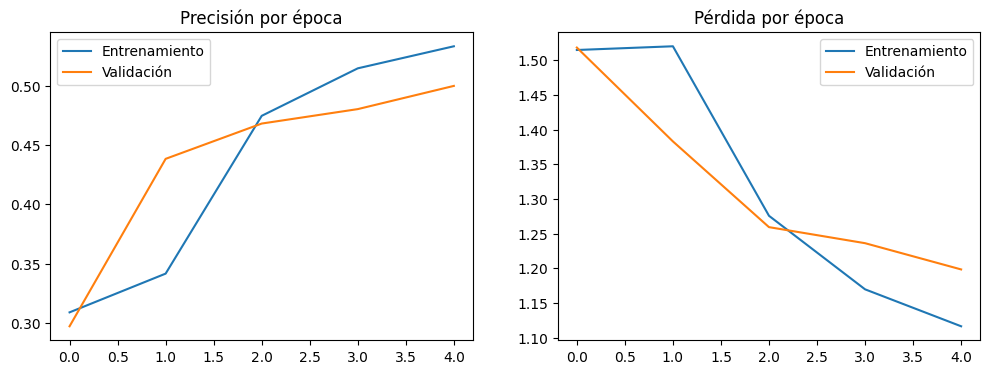

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


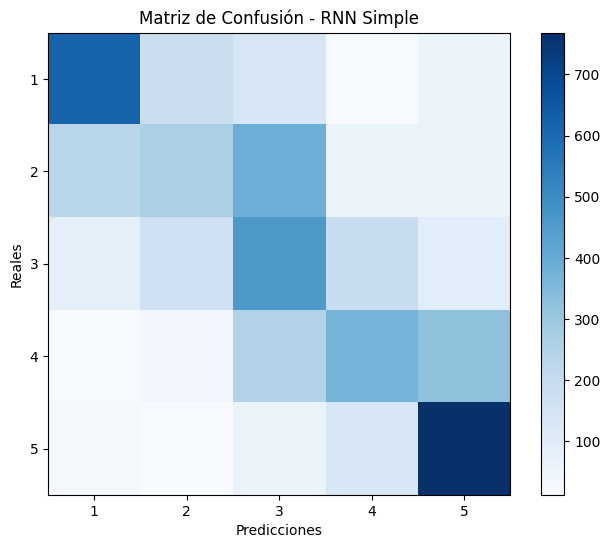

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión detallada
y_pred = model_pool.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(5), labels=range(1,6))
plt.yticks(ticks=range(5), labels=range(1,6))
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))

              precision    recall  f1-score   support

          1★       0.63      0.62      0.62      1000
          2★       0.40      0.27      0.32      1000
          3★       0.35      0.46      0.40      1000
          4★       0.48      0.37      0.42      1000
          5★       0.59      0.77      0.67      1000

    accuracy                           0.50      5000
   macro avg       0.49      0.50      0.49      5000
weighted avg       0.49      0.50      0.49      5000



**Con embeddings de 200 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos (1 a 5 estrellas)
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings
num_classes = 5                              # Por ejemplo, 5 categorías de sentimiento (1 a 5 estrellas)

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(num_classes, activation='softmax')
])

model_pool.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 204s 509ms/step - accuracy: 0.2884 - loss: 1.5387 - val_accuracy: 0.2970 - val_loss: 1.5181
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 218s 551ms/step - accuracy: 0.3124 - loss: 1.5434 - val_accuracy: 0.4384 - val_loss: 1.3829
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 478ms/step - accuracy: 0.4709 - loss: 1.3054 - val_accuracy: 0.4682 - val_loss: 1.2594
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 202s 478ms/step - accuracy: 0.5129 - loss: 1.1797 - val_accuracy: 0.4804 - val_loss: 1.2363
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 188s 481ms/step - accuracy: 0.5372 - loss: 1.1117 - val_accuracy: 0.5000 - val_loss: 1.1985


In [ ]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4883 - loss: 1.2018

Precisión en test: 0.4956


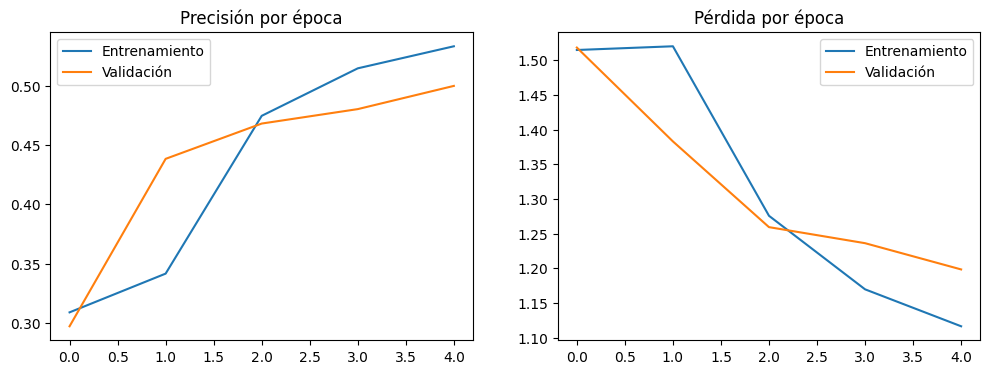

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


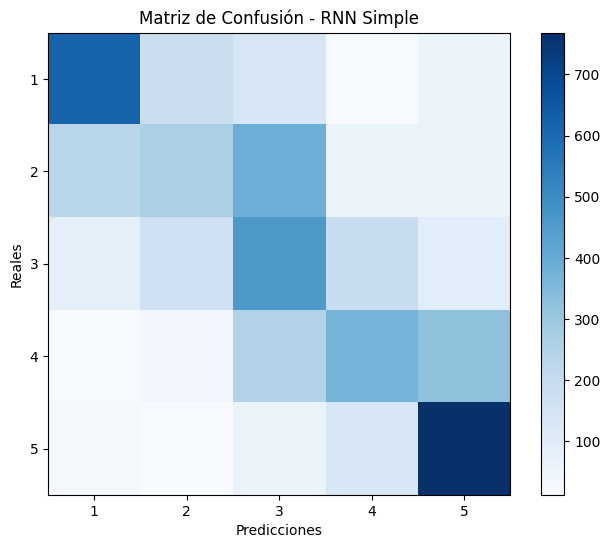

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión detallada
y_pred = model_pool.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(5), labels=range(1,6))
plt.yticks(ticks=range(5), labels=range(1,6))
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))

              precision    recall  f1-score   support

          1★       0.63      0.62      0.62      1000
          2★       0.40      0.27      0.32      1000
          3★       0.35      0.46      0.40      1000
          4★       0.48      0.37      0.42      1000
          5★       0.59      0.77      0.67      1000

    accuracy                           0.50      5000
   macro avg       0.49      0.50      0.49      5000
weighted avg       0.49      0.50      0.49      5000



**Con embeddings de 300 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos (1 a 5 estrellas)
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings
num_classes = 5                              # Por ejemplo, 5 categorías de sentimiento (1 a 5 estrellas)

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(num_classes, activation='softmax')
])

model_pool.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 204s 509ms/step - accuracy: 0.2884 - loss: 1.5387 - val_accuracy: 0.2970 - val_loss: 1.5181
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 218s 551ms/step - accuracy: 0.3124 - loss: 1.5434 - val_accuracy: 0.4384 - val_loss: 1.3829
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 478ms/step - accuracy: 0.4709 - loss: 1.3054 - val_accuracy: 0.4682 - val_loss: 1.2594
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 202s 478ms/step - accuracy: 0.5129 - loss: 1.1797 - val_accuracy: 0.4804 - val_loss: 1.2363
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 188s 481ms/step - accuracy: 0.5372 - loss: 1.1117 - val_accuracy: 0.5000 - val_loss: 1.1985


In [ ]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4883 - loss: 1.2018

Precisión en test: 0.4956


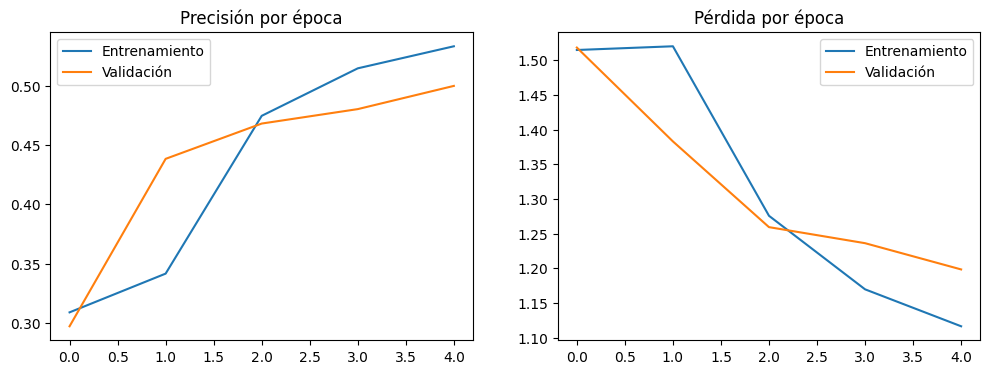

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


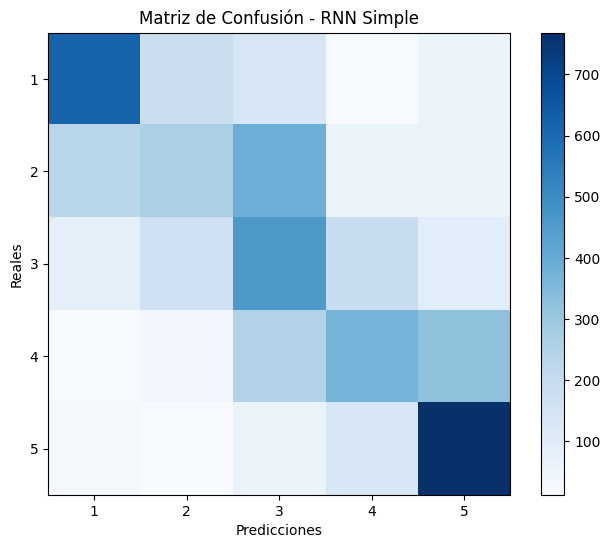

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión detallada
y_pred = model_pool.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(5), labels=range(1,6))
plt.yticks(ticks=range(5), labels=range(1,6))
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))

              precision    recall  f1-score   support

          1★       0.63      0.62      0.62      1000
          2★       0.40      0.27      0.32      1000
          3★       0.35      0.46      0.40      1000
          4★       0.48      0.37      0.42      1000
          5★       0.59      0.77      0.67      1000

    accuracy                           0.50      5000
   macro avg       0.49      0.50      0.49      5000
weighted avg       0.49      0.50      0.49      5000

